Importimine

In [ ]:
import zipfile
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from PIL import Image
from IPython.display import display

%matplotlib inline

Eeltöötlus. Võtame kõik arhiivid ning extraktime ühe kaustasse

In [2]:


zip_path = "archive.zip"
extract_path = "extracted_photos"

with zipfile.ZipFile(zip_path, "r") as zip_file:
    zip_file.extractall(extract_path)


zip_path = "archive (1).zip"
with zipfile.ZipFile(zip_path, "r") as zip_file:
    zip_file.extractall(extract_path)

zip_path = "archive (2).zip"

with zipfile.ZipFile(zip_path, "r") as zip_file:
    zip_file.extractall(extract_path)



Kood, mis eraldab kopsupõletiku bakteriaalseks ja viiruslikuks

In [3]:


#Treening and testiandmed
base_dirs = ['extracted_photos/Train', 'extracted_photos/Test', 
             'extracted_photos/chest_xray/chest_xray/train', 'extracted_photos/chest_xray/chest_xray/test',
            'extracted_photos/chest_xray/train', 'extracted_photos/chest_xray/test']


bacteria_folder = 'PNEUMONIA_BACTERIA'
virus_folder = 'PNEUMONIA_VIRUS'

for base_dir in base_dirs:
    pneumonia_path = os.path.join(base_dir, 'PNEUMONIA')
    
    if os.path.exists(pneumonia_path):
        
        bacteria_path = os.path.join(base_dir, bacteria_folder)
        virus_path = os.path.join(base_dir, virus_folder)
        os.makedirs(bacteria_path, exist_ok=True)
        os.makedirs(virus_path, exist_ok=True)
        
        for filename in os.listdir(pneumonia_path):
            if 'bacteria' in filename:
                shutil.move(os.path.join(pneumonia_path, filename), os.path.join(bacteria_path, filename))
            elif 'virus' in filename:
                shutil.move(os.path.join(pneumonia_path, filename), os.path.join(virus_path, filename))
        
        shutil.rmtree(pneumonia_path)
    else:
        print("Error")


Meetod selleks, et erinevaid dir-e arhiividest ühendada

In [4]:

def create_symlinks(src_dirs, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for src_dir in src_dirs:
        for root, dirs, files in os.walk(src_dir):
            for file in files:
                src_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, src_dir)
                dest_file_dir = os.path.join(dest_dir, relative_path)
                if not os.path.exists(dest_file_dir):
                    os.makedirs(dest_file_dir)
                dest_file = os.path.join(dest_file_dir, file)
                # Kopeeri fail sihtkausta, säilitades kataloogistruktuuri
                if not os.path.exists(dest_file):
                    shutil.copy2(src_file, dest_file)
                    
# Üksikute andmekogumite teekonnad
src_train_dirs = [
    'extracted_photos/chest_xray/chest_xray/train',
    'extracted_photos/Data/train',
    'extracted_photos/Train',
    'extracted_photos/chest_xray/train'
]

src_test_dirs = [
    'extracted_photos/chest_xray/chest_xray/test',
    'extracted_photos/Data/test',
    'extracted_photos/Test',
    'extracted_photos/chest_xray/test'
]

# Kombineeritud andmekogumi teekond
combined_train_dir = 'combined_dataset/train'
combined_test_dir = 'combined_dataset/test'

# Loome sümbollingid treening- ja testandmete jaoks
create_symlinks(src_train_dirs, combined_train_dir)
create_symlinks(src_test_dirs, combined_test_dir)

# ImageDataGenerators treeninguks ja testimiseks
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Loome treening- ja testimisgeneraatorid kombineeritud kataloogist
train_generator = train_datagen.flow_from_directory(
    combined_train_dir,
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    combined_test_dir,
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical'
)


Found 15060 images belonging to 6 classes.
Found 2520 images belonging to 6 classes.


Teeme siin 1 suur mudelit (VGG16 põhjal), mis võtab kõike train ja test andmeid ning ühendab neid edasi predictionidele

In [5]:
# Laadime VGG16 mudeli ilma ülemise klassifitseerimiskihita
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Lisame kohandatud kihid baasmodelli peale
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(train_generator.num_classes, activation='softmax')(x)

# Defineerime mudeli
big_model = models.Model(inputs=base_model.input, outputs=predictions)

# Külmutame baasmodelli kihid
for layer in base_model.layers:
    layer.trainable = False

# Kompileerime mudeli
big_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Mudeli kokkuvõte
big_model.summary()

# Andmegeneraatorid treeningu ja testimise jaoks
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Loome treening- ja testimisgeneraatorid kombineeritud kataloogist
train_generator = train_datagen.flow_from_directory(
    combined_train_dir,
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    combined_test_dir,
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical'
)

# Treenime mudelit
big_history = big_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=1,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Hinnangu andmine mudelile
test_loss, test_acc = big_model.evaluate(test_generator)
print(f"Testi täpsus: {test_acc}")

# Külmutame lahti viimased paar kihti baasmodellist peenhäälestuse jaoks
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Kompileerime mudeli uuesti madalama õppimismääraga
big_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Peenhäälestame mudelit
history_fine = big_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=1,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Hinnangu andmine peenhäälestatud mudelile
test_loss, test_acc = big_model.evaluate(test_generator)
print(f"Fine-tuned testide täpsus: {test_acc}")

# Prindime treeningu täpsuse
train_loss, train_acc = big_model.evaluate(train_generator)
print(f"Train täpsus: {train_acc}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,166 (60.14 MB)

 Trainable params: 1,049,478 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 15060 images belonging to 6 classes.
Found 2520 images belonging to 6 classes.


c:\Users\artur\anaconda3\envs\VisualStudioEnv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 443s 7s/step - accuracy: 0.5179 - loss: 1.3118 - val_accuracy: 0.7331 - val_loss: 0.7421
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.7444 - loss: 0.7226
Testi täpsus: 0.7345238327980042
58/58 ━━━━━━━━━━━━━━━━━━━━ 434s 7s/step - accuracy: 0.6123 - loss: 1.0339 - val_accuracy: 0.7678 - val_loss: 0.6339
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.7662 - loss: 0.6315
Fine-tuned testide täpsus: 0.7682539820671082
59/59 ━━━━━━━━━━━━━━━━━━━━ 351s 6s/step - accuracy: 0.7157 - loss: 0.7095
Train täpsus: 0.7155378460884094


In [14]:
def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image array
    return img_array
# Funktsioon ennustuste tegemiseks uute piltide puhul
def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)  # Load and preprocess the image
    prediction = model.predict(img_array)  # Make prediction using the model
    return prediction


Üritame teha predictioni siin

In [15]:
def tuvasta(new_images, model):
    # Add random images from "random Lung pics" folder
    new_images = new_images + ["random Lung pics/" + a for a in os.listdir("random Lung pics")]
    print(new_images)

    for img_path in new_images:
        img = Image.open(img_path)

        prediction = predict_image(model, img_path)
        class_index = np.argmax(prediction[0])
        class_label = list(train_generator.class_indices.keys())[class_index]
        print(f"Pilt {img_path} on ennustatud olevat {class_label} tõenäosusega {prediction[0][class_index]:.4f}")

        plt.imshow(img)
        plt.axis('off')
        display(plt.gcf())


['combined_dataset/test/TUBERCULOSIS/Tuberculosis-1.png', 'combined_dataset/test/PNEUMONIA/person1_virus_6.jpeg', 'combined_dataset/test/NORMAL/IM-0001-0001.jpeg', 'combined_dataset/test/COVID19/COVID19(461).jpg', 'random Lung pics/16820tn.jpg', 'random Lung pics/covid.jpg', 'random Lung pics/covidorpneumo.png', 'random Lung pics/lightbox_d5fb4780505111eba7d4a3f610d63647-thumbnail_Image1.png', 'random Lung pics/pnevmo2.jpg', 'random Lung pics/rul-pneumonia-pa.jpg', 'random Lung pics/Screenshot_2024-05-27_at_21.33.09.png', 'random Lung pics/Screenshot_2024-05-27_at_21.33.28.png', 'random Lung pics/Screenshot_2024-05-27_at_21.35.23.png', 'random Lung pics/tuber.jpg', 'random Lung pics/tuber.png', 'random Lung pics/tuber2.jpg', 'random Lung pics/tuber2.png', 'random Lung pics/Verkalkte_Granulome_der_Lungenspitze_nach_Tuberkulose_90M_-_CR_pa_-_001.jpg', 'random Lung pics/тубер2.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Pilt combined_dataset/test/TUBERCULOSIS/Tuberculosis-1.png on ennusta

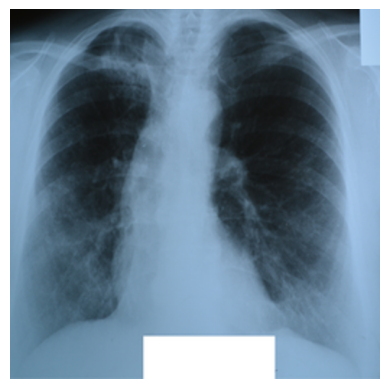

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Pilt combined_dataset/test/PNEUMONIA/person1_virus_6.jpeg on ennustatud olevat PNEUMONIA tõenäosusega 0.6990


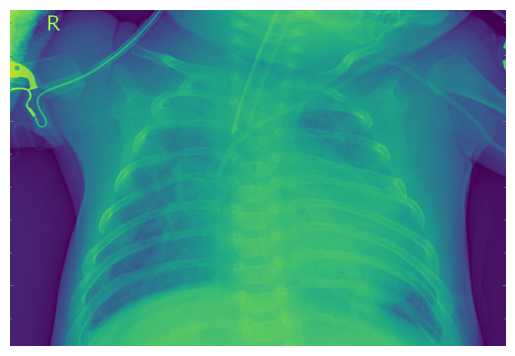

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Pilt combined_dataset/test/NORMAL/IM-0001-0001.jpeg on ennustatud olevat NORMAL tõenäosusega 0.9127


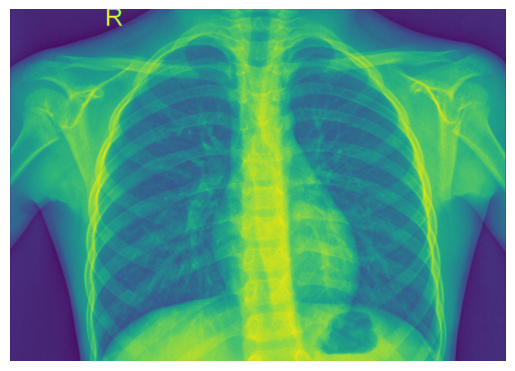

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Pilt combined_dataset/test/COVID19/COVID19(461).jpg on ennustatud olevat COVID19 tõenäosusega 0.5571


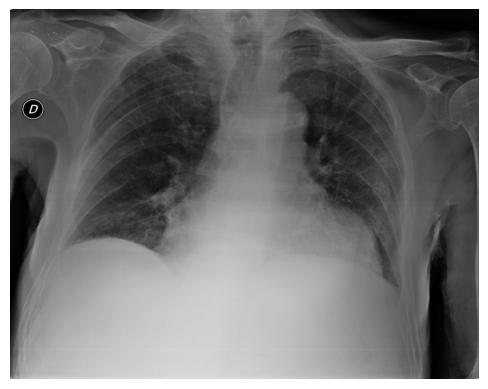

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Pilt random Lung pics/16820tn.jpg on ennustatud olevat COVID19 tõenäosusega 0.5955


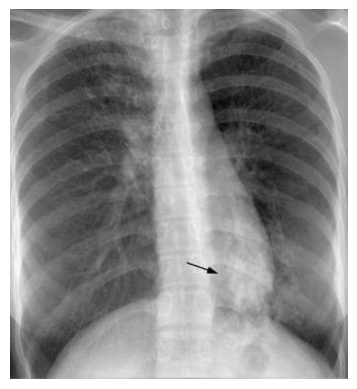

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Pilt random Lung pics/covid.jpg on ennustatud olevat PNEUMONIA tõenäosusega 0.4683


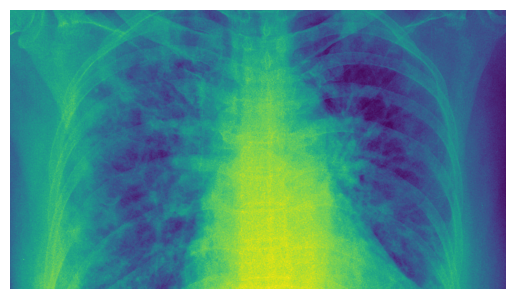

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Pilt random Lung pics/covidorpneumo.png on ennustatud olevat COVID19 tõenäosusega 0.5972


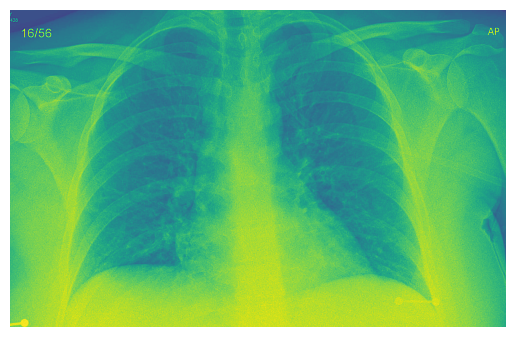

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Pilt random Lung pics/lightbox_d5fb4780505111eba7d4a3f610d63647-thumbnail_Image1.png on ennustatud olevat COVID19 tõenäosusega 0.5551


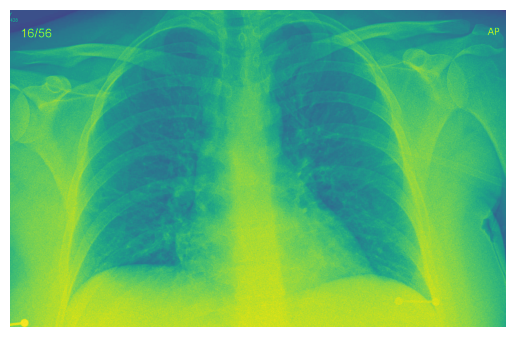

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Pilt random Lung pics/pnevmo2.jpg on ennustatud olevat TUBERCULOSIS tõenäosusega 0.5155


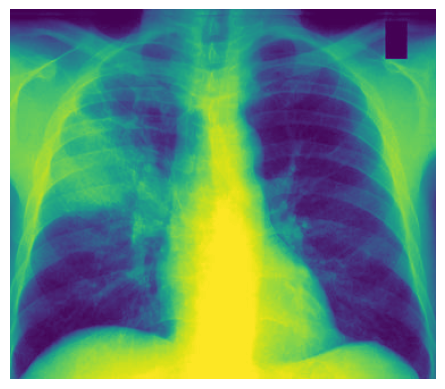

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Pilt random Lung pics/rul-pneumonia-pa.jpg on ennustatud olevat TUBERCULOSIS tõenäosusega 0.3710


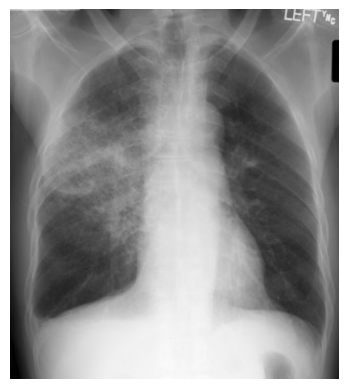

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Pilt random Lung pics/Screenshot_2024-05-27_at_21.33.09.png on ennustatud olevat TUBERCULOSIS tõenäosusega 0.9231


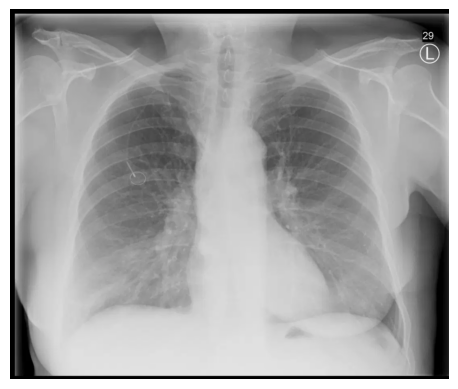

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Pilt random Lung pics/Screenshot_2024-05-27_at_21.33.28.png on ennustatud olevat COVID19 tõenäosusega 0.6325


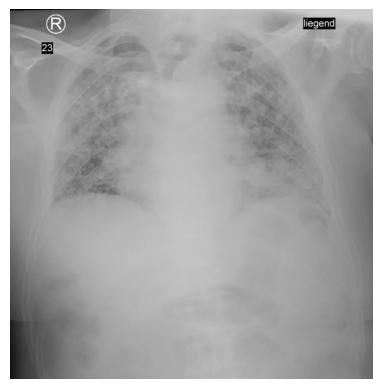

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Pilt random Lung pics/Screenshot_2024-05-27_at_21.35.23.png on ennustatud olevat COVID19 tõenäosusega 0.5017


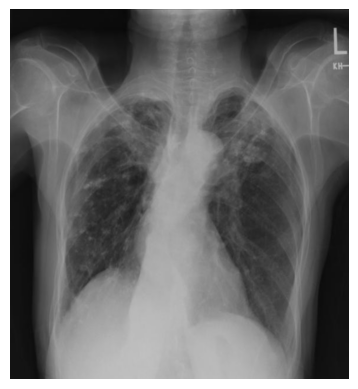

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Pilt random Lung pics/tuber.jpg on ennustatud olevat COVID19 tõenäosusega 0.6795


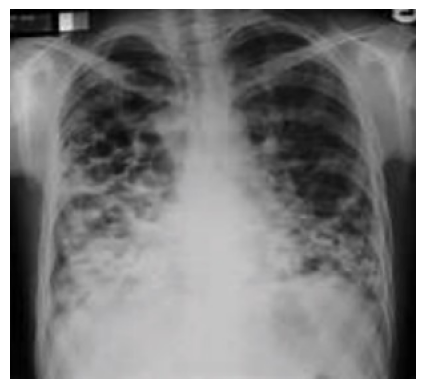

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Pilt random Lung pics/tuber.png on ennustatud olevat COVID19 tõenäosusega 0.5708


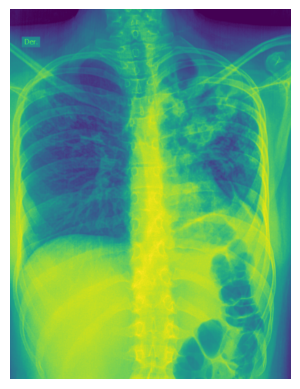

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Pilt random Lung pics/tuber2.jpg on ennustatud olevat COVID19 tõenäosusega 0.5080


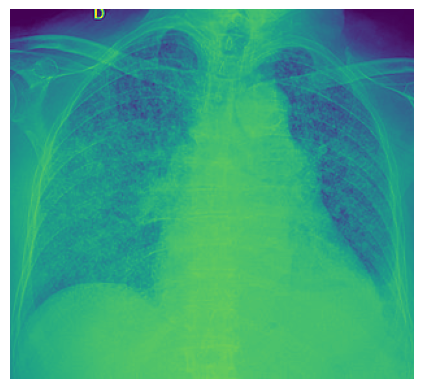

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Pilt random Lung pics/tuber2.png on ennustatud olevat COVID19 tõenäosusega 0.5708


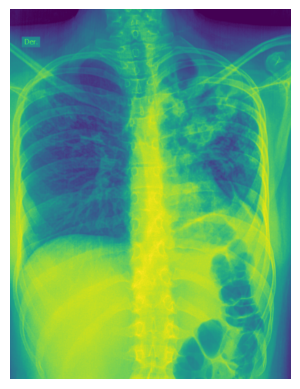

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Pilt random Lung pics/Verkalkte_Granulome_der_Lungenspitze_nach_Tuberkulose_90M_-_CR_pa_-_001.jpg on ennustatud olevat COVID19 tõenäosusega 0.6708


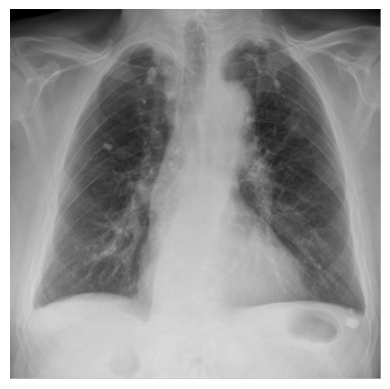

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Pilt random Lung pics/тубер2.jpg on ennustatud olevat COVID19 tõenäosusega 0.5080


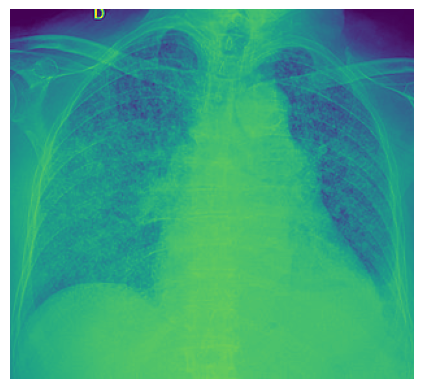

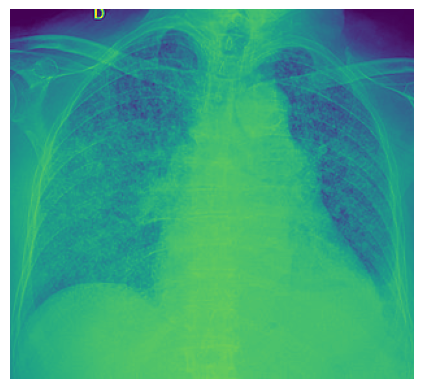

In [16]:
new_images = [
        "combined_dataset/test/TUBERCULOSIS/Tuberculosis-1.png",
        "combined_dataset/test/PNEUMONIA/person1_virus_6.jpeg",
        "combined_dataset/test/NORMAL/IM-0001-0001.jpeg",
        "combined_dataset/test/COVID19/COVID19(461).jpg"
    ]

tuvasta(new_images,big_model)

Proovime eraldada 3 datasetti nii, et iga mudel võtab oma datasetti.

In [17]:


# ZIP-failide teed ja ekstraktsioonikaust
zip_paths = ["archive.zip", "archive (1).zip", "archive (2).zip"]
extract_base_path = "extracted_photos"

# Ekstrakteerime iga ZIP-faili oma alamkausta
for i, zip_path in enumerate(zip_paths):
    # Määrame ekstraktsioonitee iga ZIP-faili jaoks
    extract_path = os.path.join(extract_base_path, f"archive_{i}")
    # Loome ekstraktsioonikataloogi, kui see ei ole juba olemas
    os.makedirs(extract_path, exist_ok=True)
    # Ekstrakteerime ZIP-faili määratud teele
    with zipfile.ZipFile(zip_path, "r") as zip_file:
        zip_file.extractall(extract_path)

# Kontrollime, kas kõik pildid on tuvastatavad
def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Kontrollime pilti
            except (IOError, SyntaxError) as e:
                print(f"Jätame vigase faili vahele: {file_path}")
                os.remove(file_path)

# Kontrollime kõiki ekstrakteeritud pilte
for i in range(len(zip_paths)):
    extract_path = os.path.join(extract_base_path, f"archive_{i}")
    validate_images(extract_path)


Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\chest_xray\.DS_Store
Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\chest_xray\test\.DS_Store
Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\chest_xray\train\.DS_Store
Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\chest_xray\train\NORMAL\.DS_Store
Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\chest_xray\train\PNEUMONIA\.DS_Store
Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\chest_xray\val\.DS_Store
Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\chest_xray\val\NORMAL\.DS_Store
Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\chest_xray\val\PNEUMONIA\.DS_Store
Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\__MACOSX\._chest_xray
Jätame vigase faili vahele: extracted_photos\archive_0\chest_xray\__MACOSX\chest_xray\._.DS_Store
Jätame vigase faili vahele: extracted_photos\arch

In [18]:

# Funktsioon andmegeneraatorite loomiseks
def create_data_generators(extract_path, img_size=(150, 150), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
    
    train_generator = datagen.flow_from_directory(
        extract_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = datagen.flow_from_directory(
        extract_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, validation_generator

# Loome andmegeneraatorid iga ekstrakteeritud arhiivi jaoks
data_generators = [create_data_generators(os.path.join(extract_base_path, f"archive_{i}")) for i in range(len(zip_paths))]

Found 9370 images belonging to 1 classes.
Found 2342 images belonging to 1 classes.
Found 1771 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 5146 images belonging to 1 classes.
Found 1286 images belonging to 1 classes.


In [19]:
# Funktsioon mudeli loomiseks
def create_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Külmutame baasmodelli kihid
    for layer in base_model.layers:
        layer.trainable = False
        
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [21]:

# Mudelite ja ajalugude hoidmine
models = []
histories = []

# Treenime mudeli iga andmegeneraatoripaari jaoks
for train_generator, validation_generator in data_generators:
    model = create_model(input_shape=(150, 150, 3), num_classes=train_generator.num_classes)
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size
    )
    models.append(model)
    histories.append(history)



# Kombineeritud mudel, mis oli enne tehtud
combined_model = big_model
combined_history = big_history

models.append(combined_model)
histories.append(combined_history)


c:\Users\artur\anaconda3\envs\VisualStudioEnv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\artur\anaconda3\envs\VisualStudioEnv\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


292/292 ━━━━━━━━━━━━━━━━━━━━ 266s 903ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9146 - loss: 0.4451 - val_accuracy: 0.9279 - val_loss: 0.2663
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 1.0000 - loss: 0.0000e+00

c:\Users\artur\anaconda3\envs\VisualStudioEnv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


History 1 contents:
{'accuracy': [1.0], 'loss': [0.0], 'val_accuracy': [1.0], 'val_loss': [0.0]}
History 2 contents:
{'accuracy': [0.9238636493682861], 'loss': [0.35499510169029236], 'val_accuracy': [0.9278846383094788], 'val_loss': [0.2663336992263794]}
History 3 contents:
{'accuracy': [1.0], 'loss': [0.0], 'val_accuracy': [1.0], 'val_loss': [0.0]}
History 4 contents:
{'accuracy': [0.5931504964828491], 'loss': [1.0849071741104126], 'val_accuracy': [0.7330729365348816], 'val_loss': [0.7420966625213623]}


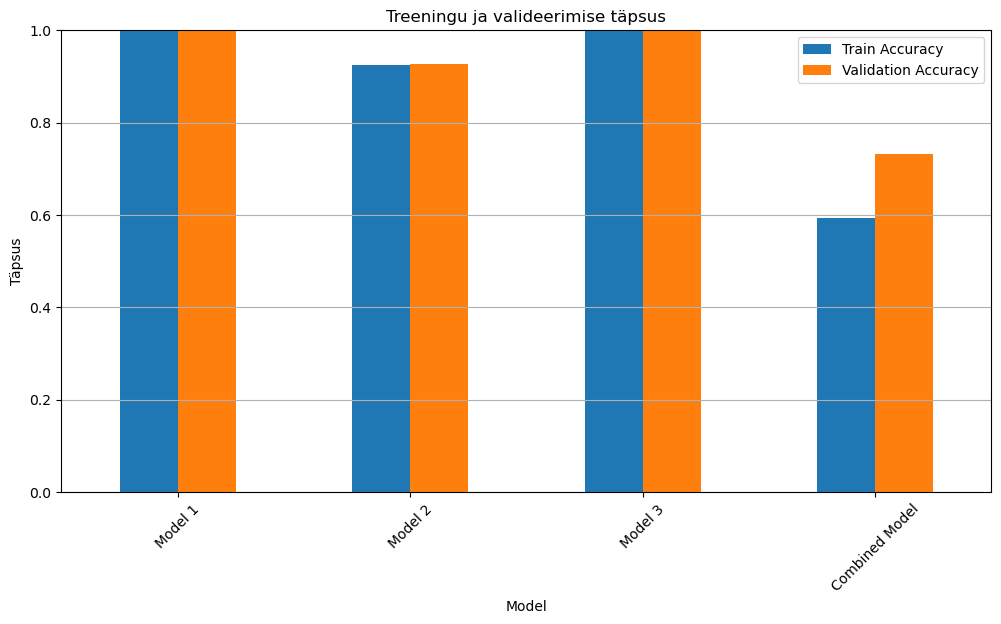

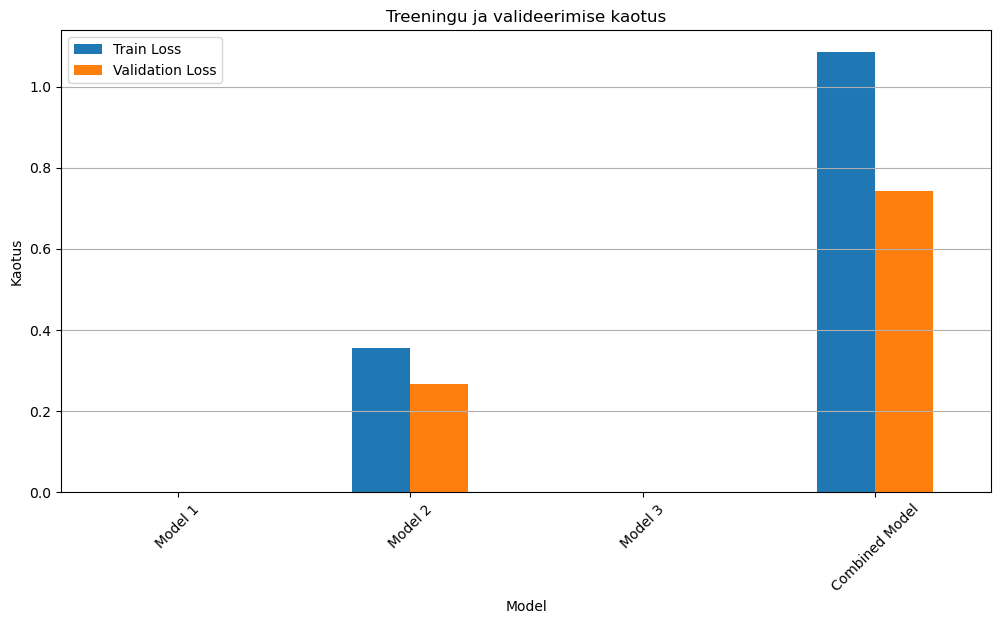

In [34]:
# Prindi iga history objekti sisu andmete kontrollimiseks
for i, history in enumerate(histories):
    print(f"History {i+1} contents:")
    print(history.history)

# Ekstrakti lõplik täpsus ja kaotusväärtused iga mudeli jaoks
model_names = [f'Model {i+1}' for i in range(len(histories) - 1)] + ['Combined Model']

train_accuracies = [history.history['accuracy'][-1] for history in histories]
val_accuracies = [history.history['val_accuracy'][-1] for history in histories]
train_losses = [history.history['loss'][-1] for history in histories]
val_losses = [history.history['val_loss'][-1] for history in histories]

# Loo DataFrame andmete paremaks käsitlemiseks
df_metrics = pd.DataFrame({
    'Model': model_names,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Validation Loss': val_losses
})

# Täpsuste joonistamine
plt.figure(figsize=(12, 6))
df_metrics.plot(kind='bar', x='Model', y=['Train Accuracy', 'Validation Accuracy'], ax=plt.gca())
plt.title('Treeningu ja valideerimise täpsus')
plt.ylabel('Täpsus')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Kaotuste joonistamine
plt.figure(figsize=(12, 6))
df_metrics.plot(kind='bar', x='Model', y=['Train Loss', 'Validation Loss'], ax=plt.gca())
plt.title('Treeningu ja valideerimise kaotus')
plt.ylabel('Kaotus')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()